# Galactic bar

Integrate the globular cluster system as point masses where the galaxy now includes a galactic bar. Thus, we no are no longer in a time-static and axis-symmetric potential

In [1]:
import tstrippy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import numpy as np
import matplotlib.pyplot as plt

## Load the units

In [2]:
unitbasis = tstrippy.Parsers.potential_parameters.unitbasis
unitT=u.Unit(unitbasis['time'])
unitV=u.Unit(unitbasis['velocity'])
unitD=u.Unit(unitbasis['distance'])
unitM=u.Unit(unitbasis['mass'])
unitG=u.Unit(unitbasis['G'])
G = const.G.to(unitG).value

## Load Galactic Parameters

In [3]:
potentialname='pouliasis2017pii'
MWparams = tstrippy.Parsers.potential_parameters.pouliasis2017pii()
MWrefframe= tstrippy.Parsers.potential_parameters.MWreferenceframe()

## Add the bar parameters

This is an artificial bar used in Ferrone et al 2023. It is not intended to perfectly model the bar, but rather provide an idea of what a bar can do to stellar streams. It uses a Long-Murali bar. This bar is a needle that has been convolved with a soften kernal to give it a triaxial-shape. 

In [4]:
# mass and size
abar = 4 * unitD
bbar = 1 * unitD
cbar = 0.5 * unitD
Mbar = 990.0*2.32*1e7 * unitM
barname = "longmuralibar"
barparams = [MWparams[0],Mbar.value,abar.value,bbar.value,cbar.value]
# oreitnation and bar pattern speed
theta0= 25 * (np.pi/180) 
omega =  28  * 2*np.pi * unitV / unitD
omega = -omega.value
barpolycoeff=[theta0,omega]

## Reduce the mass of the disks
Since we are adding a bar, we need to reduce the mass of the disks

In [5]:
MWparams[5] = 1120.0 * 2.32*10**7 
MWparams[8] = 1190.0 * 2.32*10**7 

## Set integration time

Do this in years so that you can assure the number of timesteps is an integer, and then convert the total time *T* and the timestep *dt* into integration units.

In [6]:
integrationtime,dt = 5e9,1e5
Ntimestep=int(integrationtime/dt)
integrationtime,dt=integrationtime*u.yr,dt*u.yr
dt=dt.to(unitT)
currenttime = 0.0*unitT
integrationparams = [currenttime,dt,Ntimestep]

## Load the Globular Clusters
Store them in an astropy object to store them to galactocentric coordinates

In [7]:
GCdata  =   tstrippy.Parsers.baumgardtMWGCs().data
skycoordinates=coord.SkyCoord(
    ra=GCdata['RA'],
    dec=GCdata['DEC'],
    distance=GCdata['Rsun'],
    pm_ra_cosdec=GCdata['mualpha'],
    pm_dec=GCdata['mu_delta'],
    radial_velocity=GCdata['RV'],)
galacticcoordinates = skycoordinates.transform_to(MWrefframe)
x,y,z=galacticcoordinates.cartesian.xyz.to(unitD).value
vx,vy,vz=galacticcoordinates.velocity.d_xyz.to(unitV).value
# grab the number of objects
Nobj=len(x)


## Initialize the integrator

organize the input arguments

In [8]:
staticgalaxy = [potentialname,MWparams]
initialkinematics = [x,y,z,vx,vy,vz]
integrationparams = [currenttime.value,dt.value,Ntimestep]
galacticbar = [barname,barparams,barpolycoeff]
leapfropintime = [Ntimestep,Nobj]

input the arguments and compute the integral

In [33]:
tstrippy.integrator.setstaticgalaxy(*staticgalaxy)
tstrippy.integrator.setinitialkinematics(*initialkinematics)
tstrippy.integrator.setintegrationparameters(*integrationparams)
# tstrippy.integrator.setbackwardorbit()
tstrippy.integrator.initgalacticbar(*galacticbar)
xt,yt,zt,vxt,vyt,vzt=tstrippy.integrator.leapfrogintime(*leapfropintime)
timestamps = tstrippy.integrator.timestamps.copy()
tstrippy.integrator.deallocate()

## Analyize the change in energy

In [34]:
E0 = np.zeros(Nobj)
_,_,_,phi0=tstrippy.potentials.pouliasis2017pii(MWparams,xt[:,0],yt[:,0],zt[:,0])
_,_,_,phiF=tstrippy.potentials.pouliasis2017pii(MWparams,xt[:,-1],yt[:,-1],zt[:,-1])
T0 = 0.5*(vxt[:,0]**2+vyt[:,0]**2+vzt[:,0]**2)
TF = 0.5*(vxt[:,-1]**2+vyt[:,-1]**2+vzt[:,-1]**2)

E0 = T0 + phi0
EF = TF + phiF
Lz0 = xt[:,0]*vyt[:,0]-yt[:,0]*vxt[:,0]
LzF = xt[:,-1]*vyt[:,-1]-yt[:,-1]*vxt[:,-1]

In [35]:
import matplotlib
colors = matplotlib.cm.rainbow(np.linspace(0,1,Nobj))
# make the font size bigger and also us Latex font
plt.rc('text', usetex=True)
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

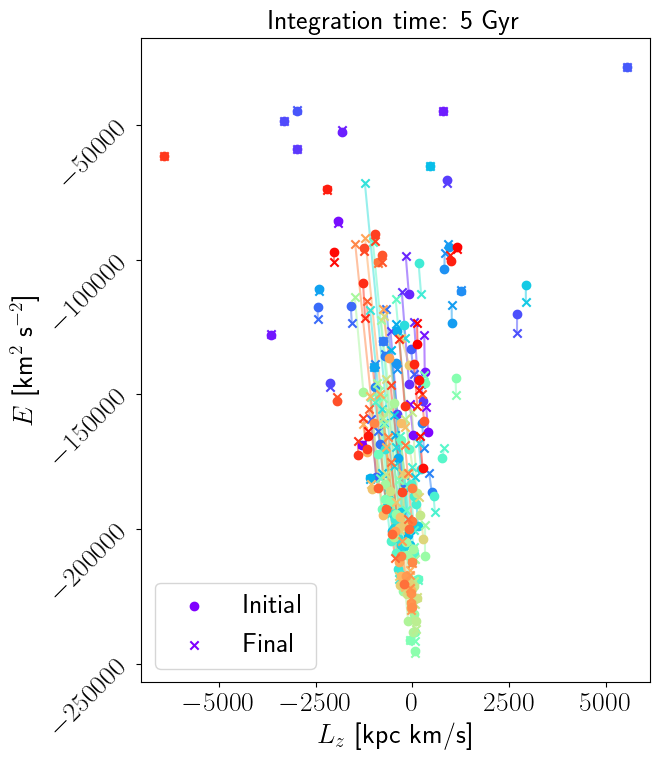

In [36]:
fig,axis=plt.subplots(1,1,figsize=(7,8))
AXIS = {
    "xlabel": r"$L_z$ [kpc km/s]",
    "ylabel": r"$E$ [km$^{2}$ s$^{-2}$]",
    "title": "Integration time: {:d} Gyr".format(int(integrationtime.to(u.Gyr).value)),
}
for i in range(Nobj):
    if i ==0:
        axis.scatter(Lz0[i],E0[i],color=colors[i],label="Initial")
        axis.scatter(LzF[i],EF[i],color=colors[i],marker='x',label="Final")
    else:
        axis.scatter(Lz0[i],E0[i],color=colors[i])
        axis.scatter(LzF[i],EF[i],color=colors[i],marker='x')
    axis.plot([Lz0[i],LzF[i]],[E0[i],EF[i]],color=colors[i],alpha=0.5,zorder=0)
axis.set(**AXIS)
axis.tick_params(axis='y', rotation=45)
axis.legend()
fig.tight_layout()  

In [37]:
idx = np.argmax(np.abs(E0 - EF))
# targetGC = "NGC5139"
targetGC=GCdata['Cluster'][idx]
targetGC="NGC6304"
idx = np.where(GCdata['Cluster']==targetGC)[0][0]

In [38]:
nstamps = len(timestamps)
colors = matplotlib.cm.rainbow(np.linspace(0,1,nstamps))

(-20.0, 20.0)

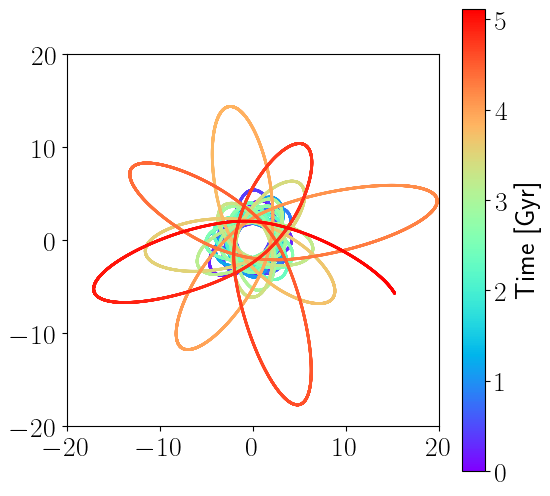

In [ ]:
fig,axis=plt.subplots(1,1,figsize=(6,6))    
im=axis.scatter(xt[idx,:],yt[idx,:],c=timestamps,marker='o',s=1,cmap=plt.cm.rainbow)
cbar=fig.colorbar(im,ax=axis)
cbar.set_label("Time [Gyr]",)
axis.set_aspect("equal")
axis.set_xlim(-20,20);
axis.set_ylim(-20,20);

In [40]:
thetaT = np.polyval(barpolycoeff[::-1],timestamps)
thetaT = np.array([thetaT[i]%(2*np.pi) for i in range(nstamps)])
def trasform_to_bar_frame(x,y,theta):
    xbar = x*np.cos(theta) + y*np.sin(theta)
    ybar = -x*np.sin(theta) + y*np.cos(theta)
    return xbar,ybar

In [45]:
xbar,ybar = trasform_to_bar_frame(xt[idx,:],yt[idx,:],thetaT)
FxBar,FyBar,FzBar,phiBar = tstrippy.potentials.longmuralibar(barparams,xbar,ybar,zt[idx,:])
T = vxt[idx,:]**2 + vyt[idx,:]**2 + vzt[idx,:]**2 
FxSG,FySG,FzSG,phiSG=tstrippy.potentials.pouliasis2017pii(MWparams,xt[idx,:],yt[idx,:],zt[idx,:])
E = 0.5*T + phiSG+phiBar
rt = np.sqrt(xt[idx,:]**2 + yt[idx,:]**2 + zt[idx,:]**2)
Rt= np.sqrt(xt[idx,:]**2 + yt[idx,:]**2)

FSG=np.sqrt(FxSG**2 + FySG**2 + FzSG**2)
FBar=np.sqrt(FxBar**2 + FyBar**2 + FzBar**2)

Text(0.5, 0, 'Time [~Gyr]')

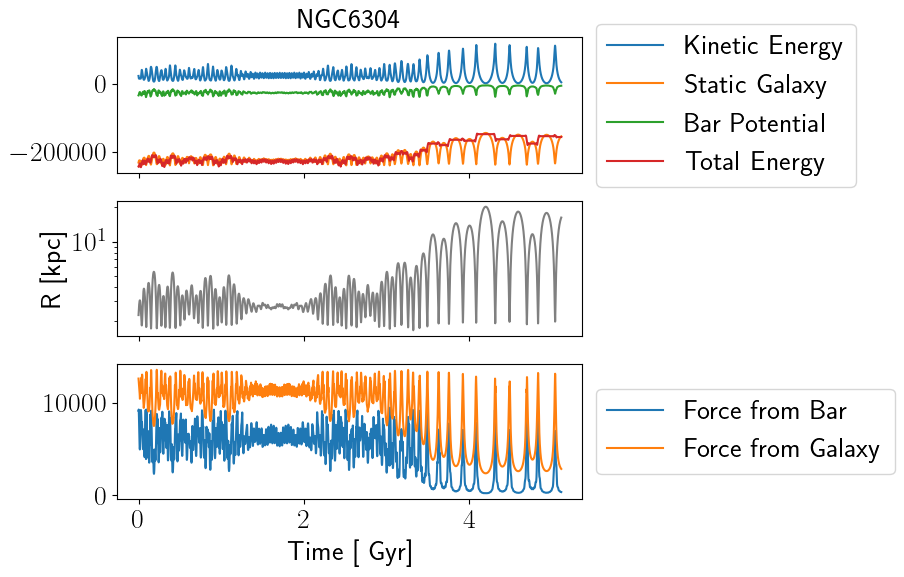

In [47]:
fig,axis=plt.subplots(3,1,figsize=(6,6),sharex=True)
axis[0].plot(timestamps,T/2,label="Kinetic Energy")
axis[0].plot(timestamps,phiSG,label="Static Galaxy")
axis[0].plot(timestamps,phiBar,label="Bar Potential")
axis[0].plot(timestamps,E,label="Total Energy")
axis[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axis[0].set_title(targetGC)
axis[1].plot(timestamps,Rt,color="grey")
axis[1].set_ylabel("R [kpc]")
axis[1].set_yscale("log")

axis[2].plot(timestamps,FBar,label="Force from Bar")
axis[2].plot(timestamps,FSG, label="Force from Galaxy")
axis[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axis[2].set_xlabel("Time [~Gyr]")